In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import numpy as np
np.set_printoptions(edgeitems=20, precision=3, linewidth=160)
import matplotlib.pyplot as plt
fig_width = 12
%matplotlib inline


# the switching binomial generative model


In [2]:
import bayesianchangepoint as bcp

seed = 51 #119 #2017 # 42
np.random.seed(seed)

mode = 'expectation'
N_blocks = 3 
N_trials = 500
max_run_length = 350
Jeffreys = False
Jeffreys = True
tau = N_trials/10.
h = 1./tau
(trials, p) = bcp.switching_binomial_motion(N_trials=N_trials, N_blocks=N_blocks, tau=tau, seed=seed, Jeffreys=Jeffreys)


## performing inference: application to synthetic data

i_block= 0


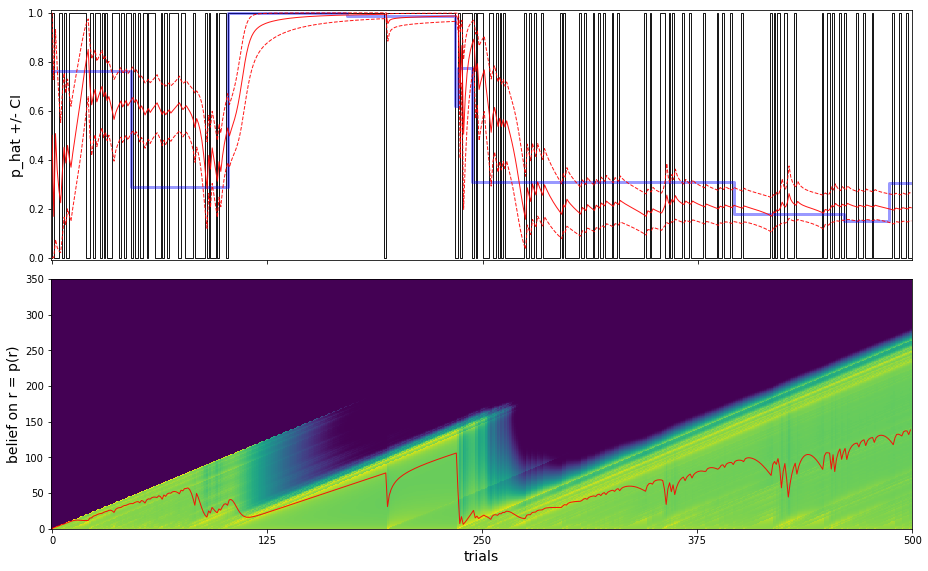

i_block= 1


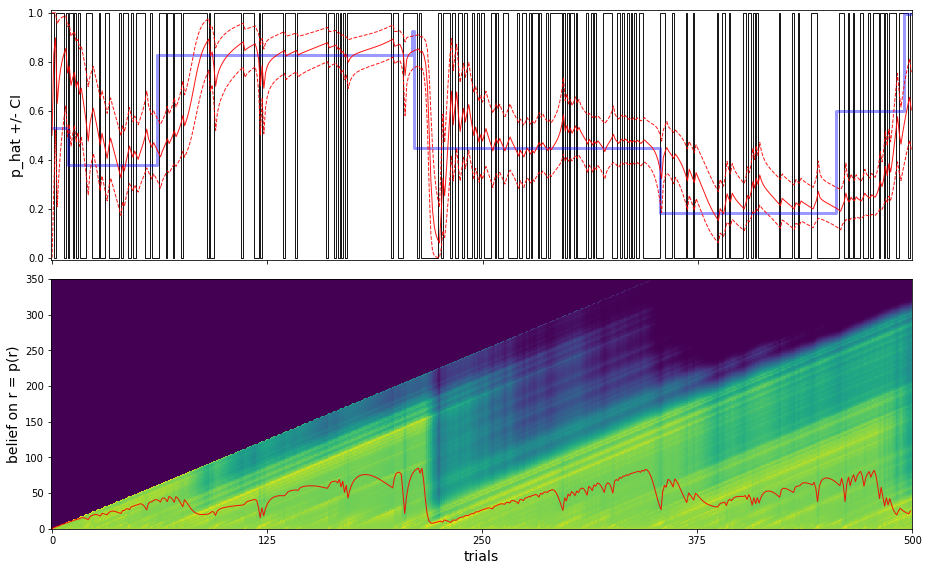

i_block= 2


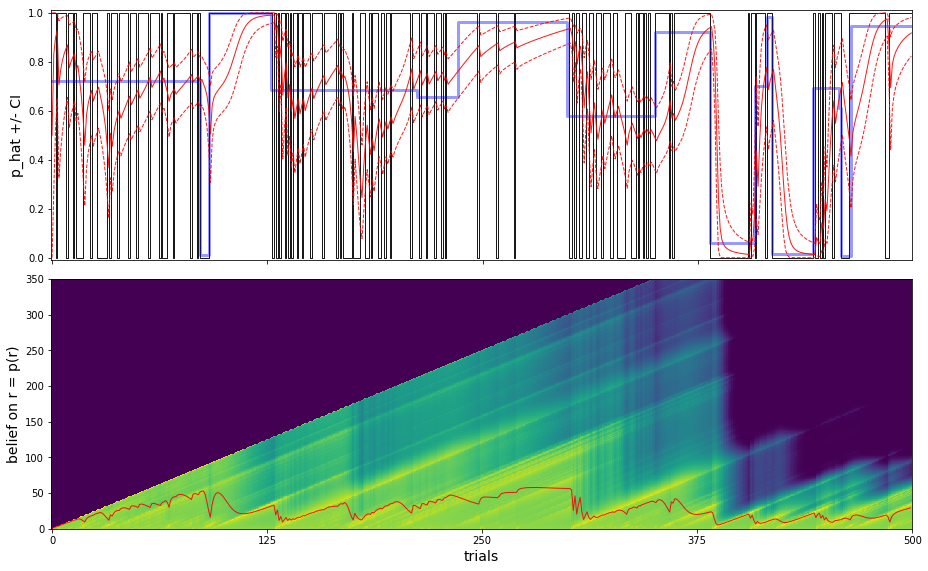

In [3]:
for i_block in range(N_blocks):
    print('i_block=', i_block)
    o = p[:, i_block, 0]
    p_bar, r, beliefs = bcp.inference(o, h=h, p0=.5, r0=.5)
    fig, axs = bcp.plot_inference(p[:, i_block, 0], p[:, i_block, 1], p_bar, r, beliefs, mode=mode, max_run_length=max_run_length)
    plt.show()

## testing different modes & hazard rates

mode expectation


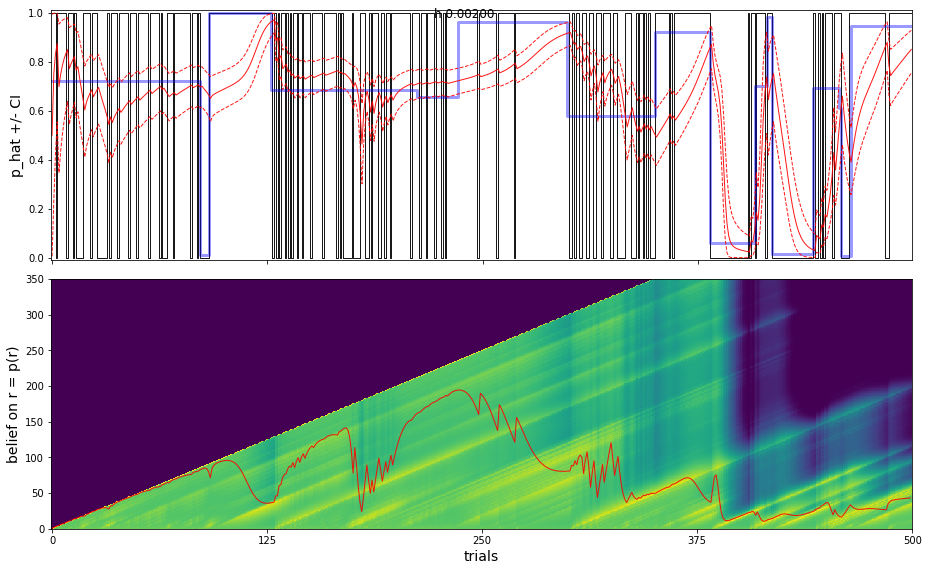

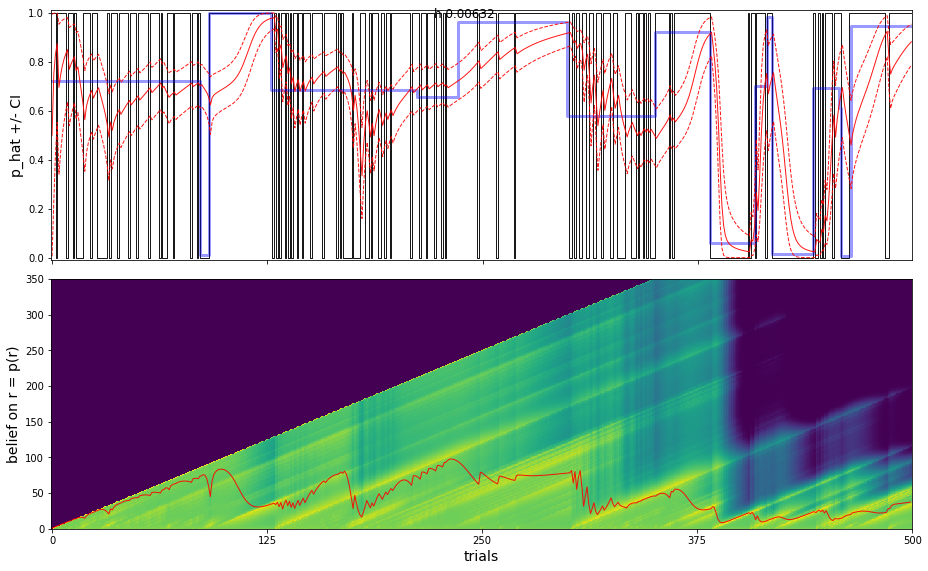

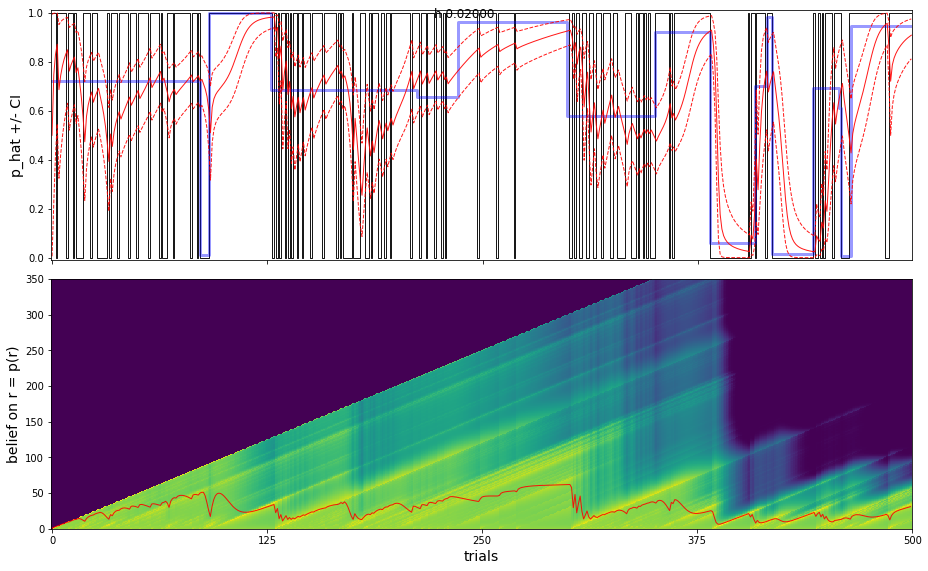

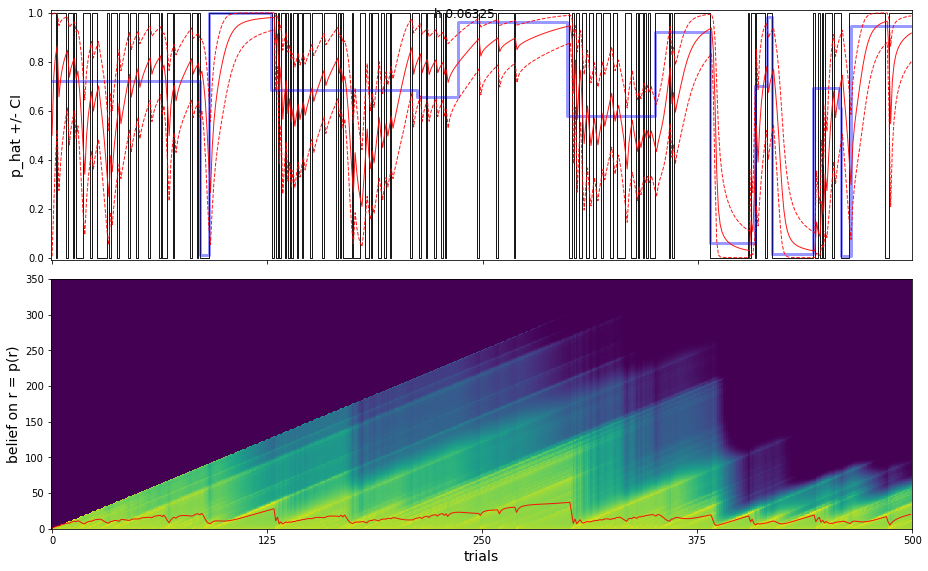

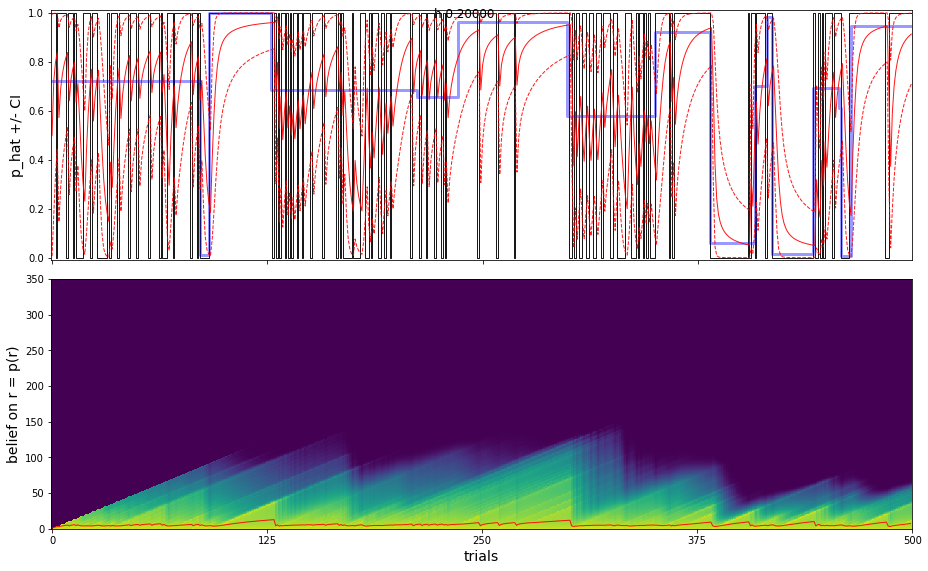

mode max


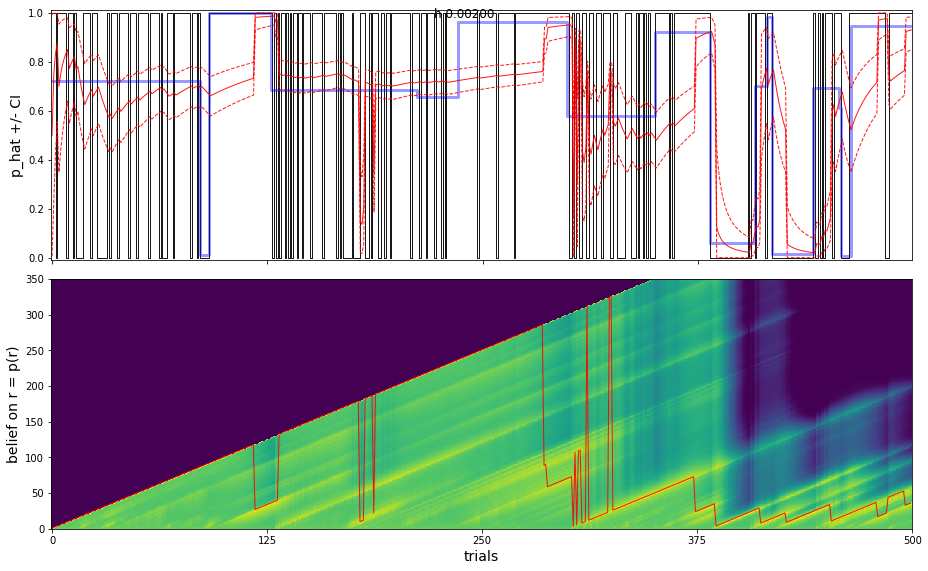

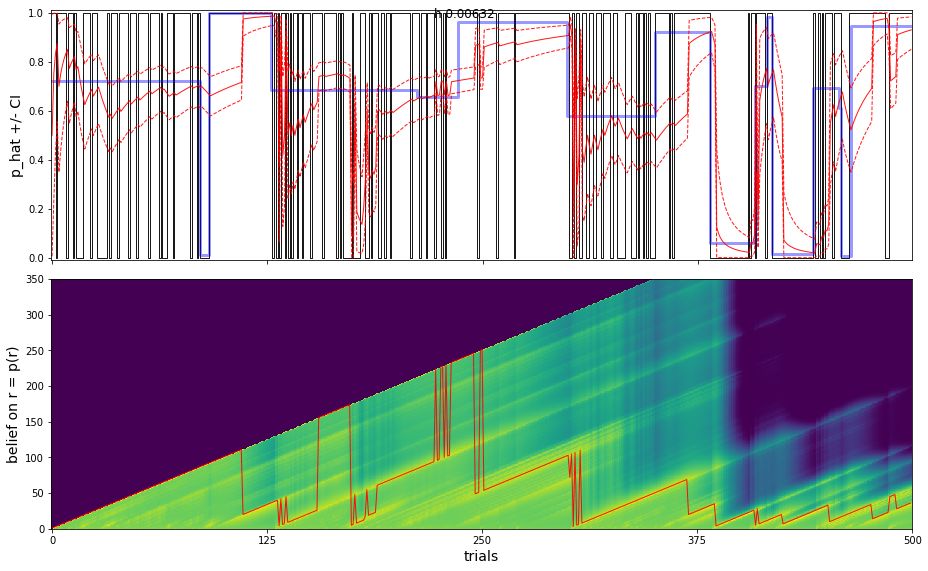

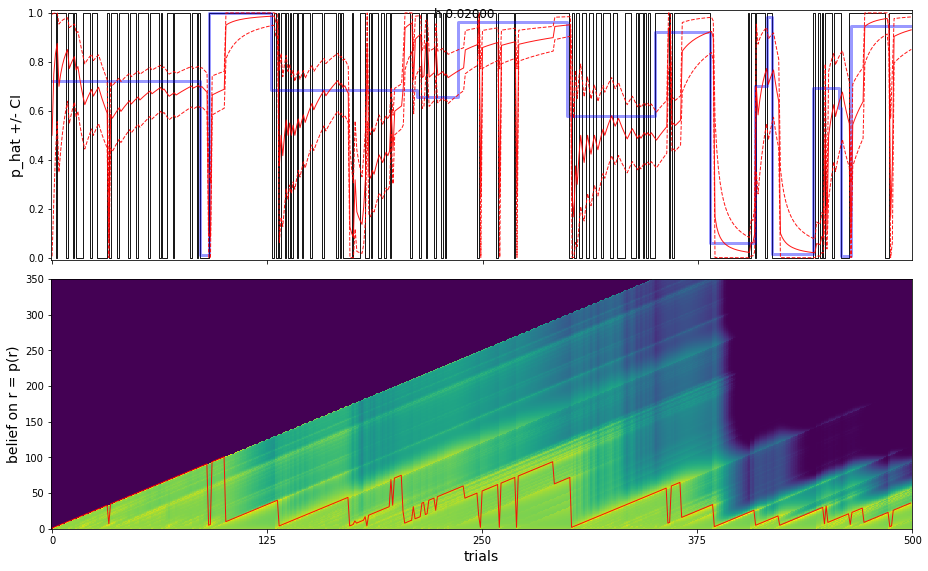

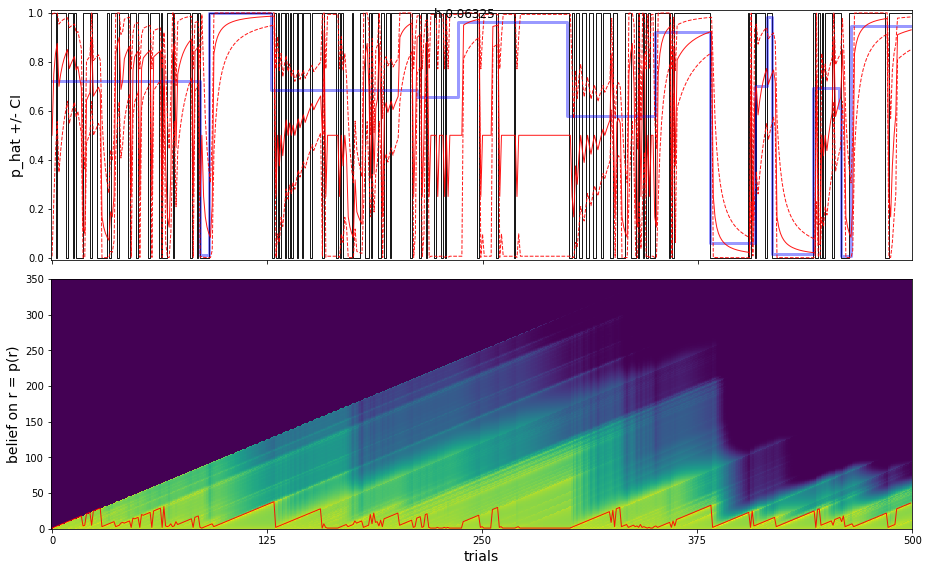

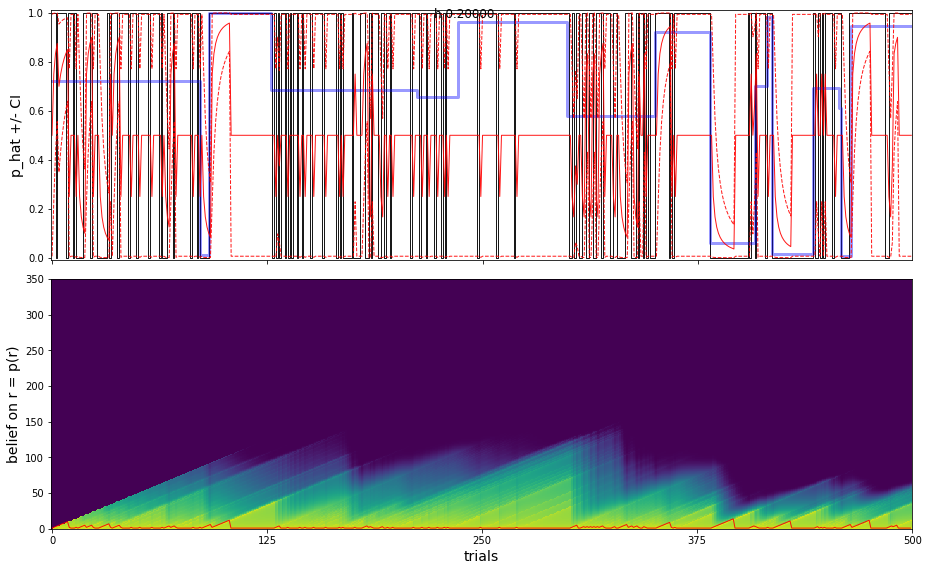

mode hindsight


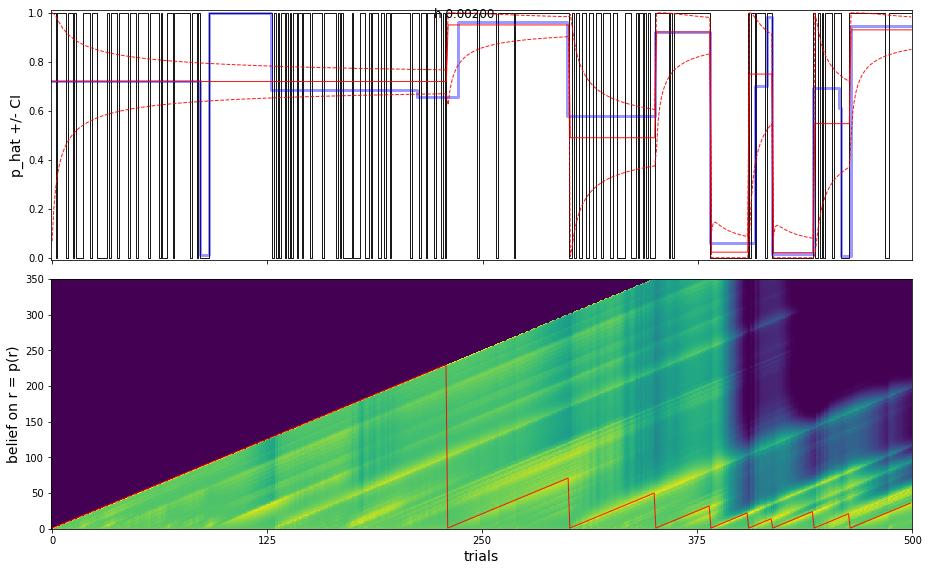

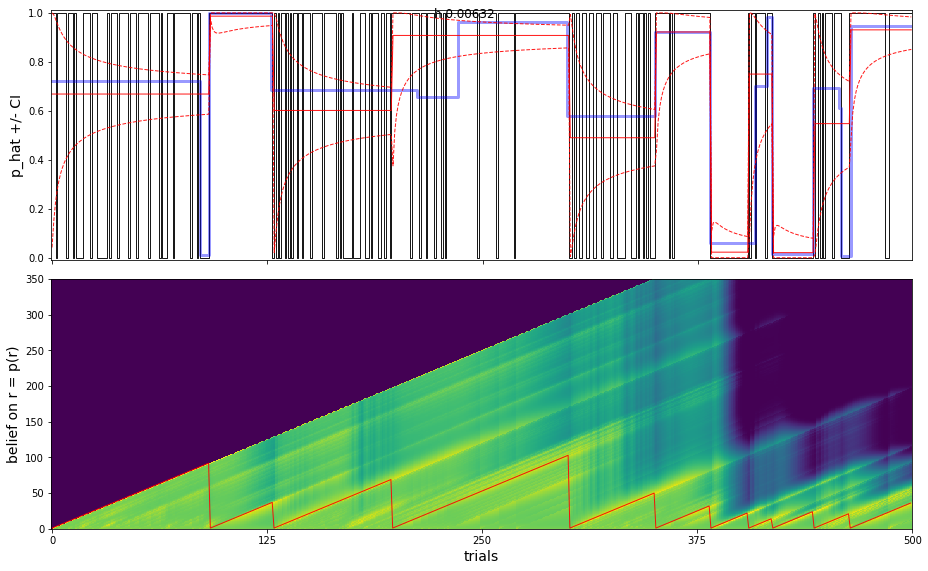

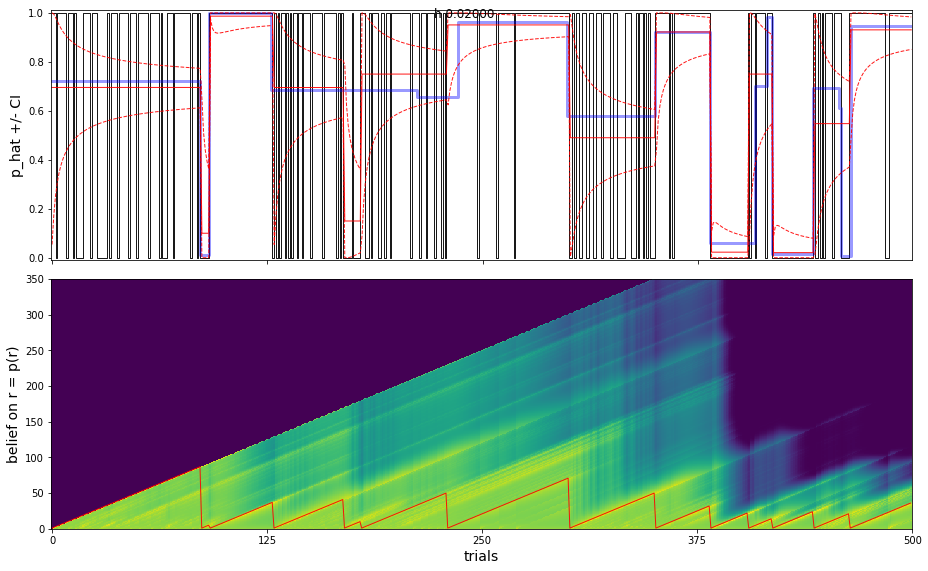

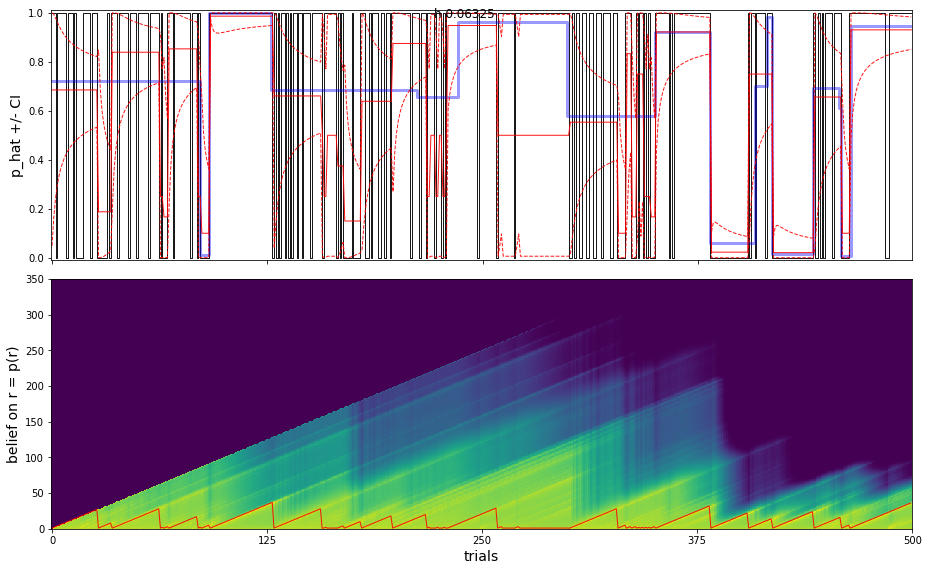

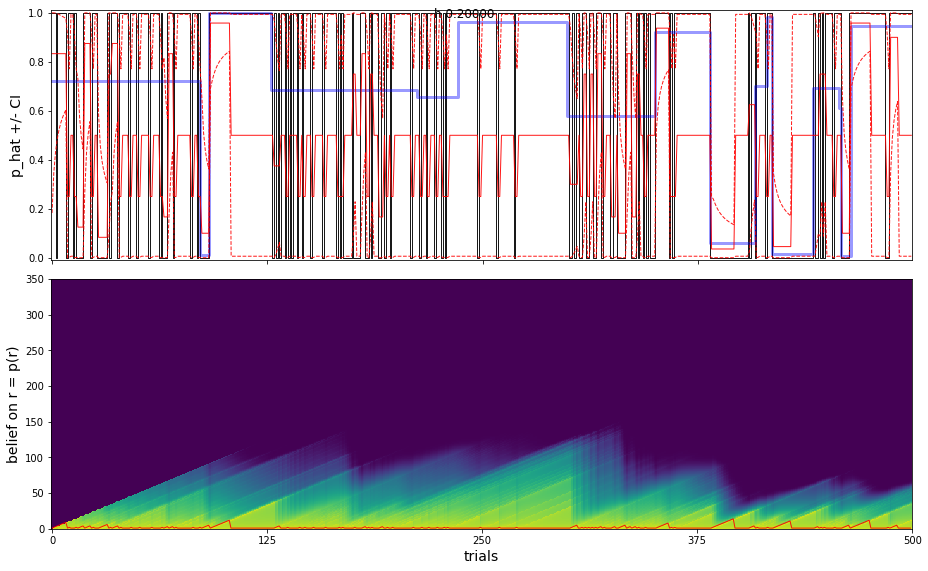

mode fixed


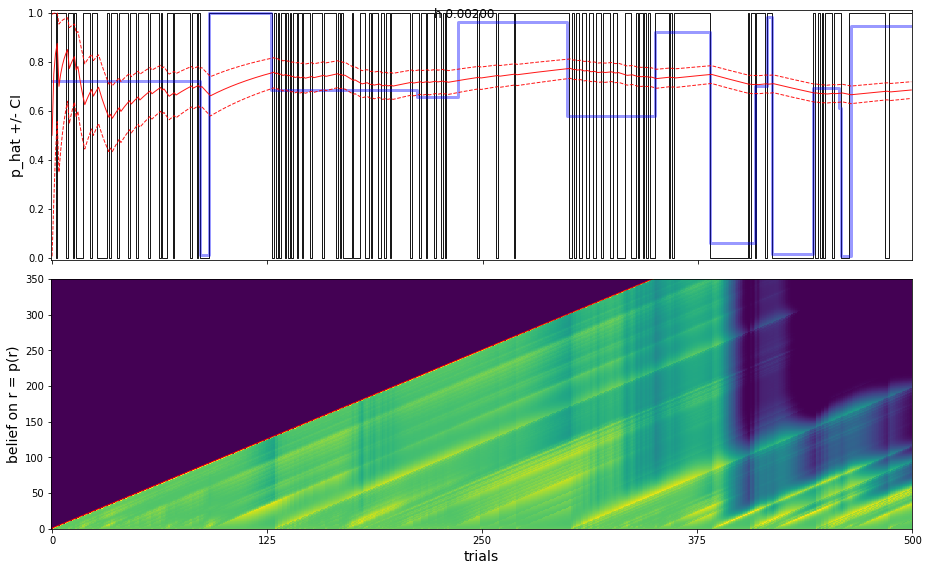

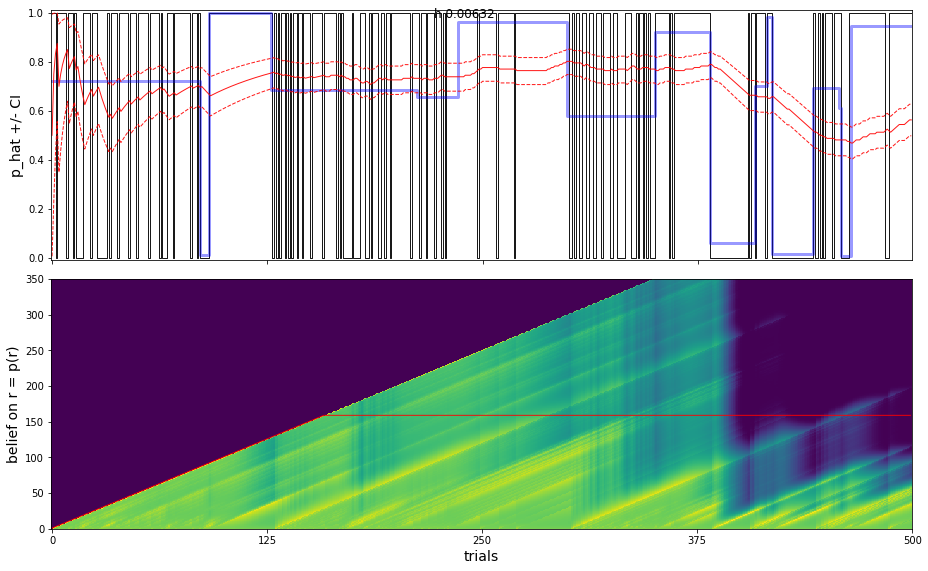

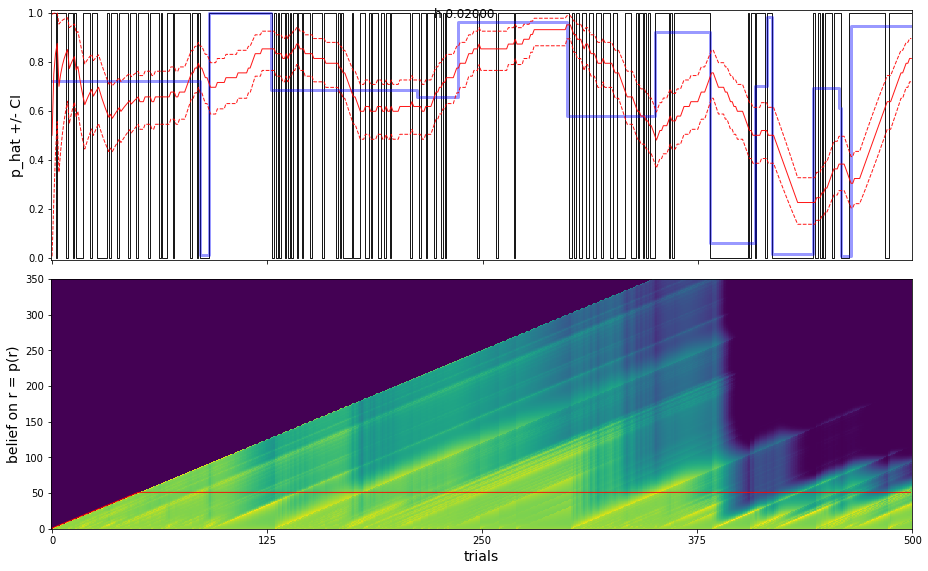

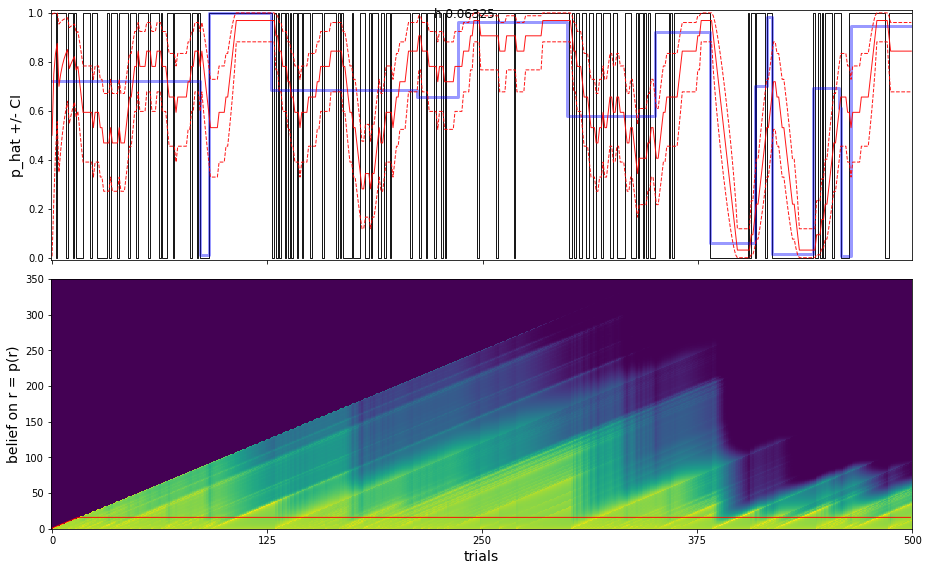

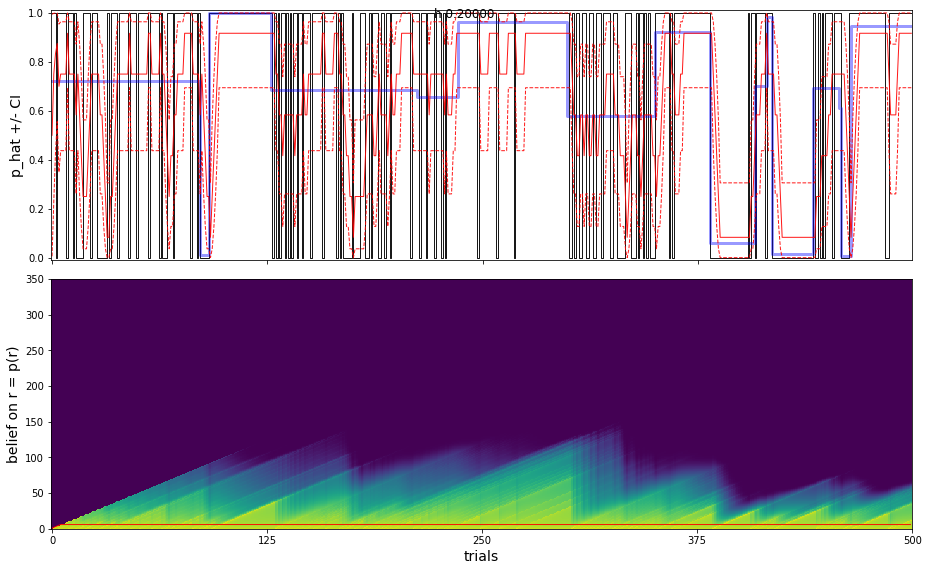

In [4]:
hs = h*np.logspace(-1., 1., 5)
modes = ['expectation', 'max', 'hindsight', 'fixed']
for mode_ in modes:
    print('mode', mode_)
    for h_ in hs:
        o = p[:, i_block, 0]
        p_bar, r, beliefs = bcp.inference(o, h=h_, p0=.5)
        if mode_=='fixed': 
                fig, axs = bcp.plot_inference(o, p[:, i_block, 1], p_bar, r, beliefs, mode=mode_, max_run_length=max_run_length, fixed_window_size=int(1/h_))
        else:
            fig, axs = bcp.plot_inference(o, p[:, i_block, 1], p_bar, r, beliefs, mode=mode_, max_run_length=max_run_length)

        
        fig.suptitle('h %.5f' % h_)
        plt.show()

## evaluating the best hazard rate using a likelihood score

In [5]:

N_scan = 7 # number of h values we test

N_blocks = 20 # number of blocks we use in our evaluation

N_scan = 15 # number of h values we test

N_blocks = 100 # number of blocks we use in our evaluation


#Jeffreys = True
#Jeffreys = False

#N_trials = 1200
#tau = N_trials/5.
#h = 1./tau

border = N_trials//2
border = 0

(trials, p) = bcp.switching_binomial_motion(N_trials=N_trials, N_blocks=N_blocks, tau=tau, seed=seed, Jeffreys=Jeffreys)

hs = h*np.logspace(-2, 1, N_scan, base=10)
modes = ['expectation', 'max', 'fixed']
modes = ['expectation', 'max', 'hindsight', 'fixed']
score = np.zeros((len(modes), N_scan, N_blocks))
for i_block in range(N_blocks):
    o = p[:, i_block, 0] # observations
    for i_scan, h_ in enumerate(hs):
        p_bar, r, beliefs = bcp.inference(o, h=h_, p0=.5, r0=2.-Jeffreys)
        for i_mode, mode_ in enumerate(modes):
            if mode_=='fixed': 
                p_hat, r_hat = bcp.readout(p_bar, r, beliefs, mode=mode_, fixed_window_size=int(1/h_))
            else:
                p_hat, r_hat = bcp.readout(p_bar, r, beliefs, mode=mode_)
            
            #score[i_mode, i_scan, i_block] = np.mean(np.log2(1.e-12+bcp.likelihood(o[border:], p_hat[border:], r_hat[border:])))

            score[i_mode, i_scan, i_block] = np.mean(np.log2(1.e-12+bcp.likelihood(p[border:, i_block, 1], p_hat[border:], r_hat[border:])))

            #score[i_mode, i_scan, i_block] = np.mean(np.abs(p_hat[border:-1] - p[(border+1):, i_block, 1]))

            #score[i_mode, i_scan, i_block] = np.mean(np.abs(p_hat[border:] - p[border:, i_block, 1]))

            #score[i_mode, i_scan, i_block] = np.log2(np.mean(bcp.likelihood(o[(border+1):], p_hat[border:-1], r_hat[border:-1])))

            

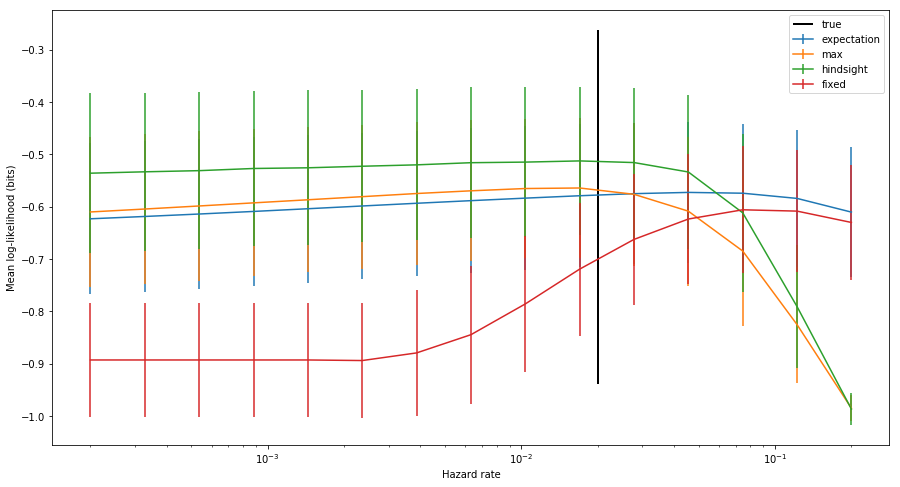

In [6]:
#fig, ax = plt.subplots(1, 1, figsize=(8, 5))
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
for i_mode, mode in enumerate(modes):
    ax.errorbar(hs, np.nanmean(score[i_mode, ...], axis=1), yerr=np.std(score[i_mode, ...], axis=1), label=mode)

ax.vlines(h, ymin=np.nanmin(np.nanmean(score, axis=(0))), ymax=np.nanmax(np.nanmean(score, axis=(0))), lw=2, label='true')
ax.set_xscale("log")#, nonposx='clip')

ax.set_xlabel('Hazard rate')
ax.set_ylabel('Mean log-likelihood (bits)')
#ax.set_ylabel('Log of mean likelihood (bits)')
ax.legend();

In [7]:
np.nanmin(score), np.nanmax(score)

(-1.09127402958062, -0.20359786788700512)

In [8]:
print(np.nanmean(score, axis=(-1)))

[[-0.623 -0.619 -0.614 -0.609 -0.604 -0.599 -0.593 -0.588 -0.584 -0.579 -0.575 -0.573 -0.574 -0.584 -0.61 ]
 [-0.61  -0.604 -0.599 -0.593 -0.587 -0.581 -0.575 -0.57  -0.565 -0.564 -0.576 -0.608 -0.685 -0.825 -0.985]
 [-0.536 -0.533 -0.531 -0.527 -0.526 -0.523 -0.52  -0.516 -0.515 -0.512 -0.516 -0.534 -0.612 -0.791 -0.986]
 [-0.893 -0.893 -0.893 -0.893 -0.893 -0.894 -0.879 -0.844 -0.786 -0.719 -0.662 -0.623 -0.606 -0.608 -0.63 ]]
